<a href="https://colab.research.google.com/github/ELMohamedAyoub/Deepfake-Content-Detection/blob/master/multimodal%2Bv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets
!pip install -q newspaper3k

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 8.5 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahinaik123/fakeddit-dataset")

print("Path to dataset files:", path)

100%|██████████| 785M/785M [00:10<00:00, 77.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mahinaik123/fakeddit-dataset/versions/1


In [3]:
# @title Cell 2: Load Fakeddit from Kaggle Cache
import pandas as pd
import os
import glob

# 1. Define the path provided by the download output
CACHE_DIR = "/root/.cache/kagglehub/datasets/mahinaik123/fakeddit-dataset/versions/1"

print(f"Searching for dataset files in: {CACHE_DIR}...")

# 2. Find the TSV files
# We look for 'multimodal_test_public.tsv' for a manageable first run.
# If you want the full training set later, change 'test' to 'train'.
search_pattern = os.path.join(CACHE_DIR, "*multimodal_test_public*.tsv")
found_files = glob.glob(search_pattern)

# Fallback if specific file not found (grab any tsv)
if not found_files:
    found_files = glob.glob(os.path.join(CACHE_DIR, "*.tsv"))

if not found_files:
    raise FileNotFoundError(f"No .tsv files found in {CACHE_DIR}")

target_file = found_files[0]
print(f"✅ Found dataset file: {os.path.basename(target_file)}")

# 3. Load Data
df = pd.read_csv(target_file, sep='\t')

# 4. Clean & Standardize Columns
# Fakeddit standard keys: author, clean_title, created_utc, domain, hasImage, id, image_url, linked_submission_id, num_comments, score, subreddit, title, upvote_ratio, 2_way_label, 3_way_label, 6_way_label
desired_cols = ['clean_title', 'image_url', '2_way_label']

# Rename if necessary to match our pipeline (text, image_url, label)
df = df[desired_cols].copy()
df.columns = ['text', 'image_url', 'label']

# 5. Filter for Valid Images
# We only want rows with valid http links
df = df[df['image_url'].notna()]
df = df[df['image_url'].str.startswith('http')]

print(f"✅ Dataset Index Loaded Successfully.")
print(f"Total Samples: {len(df)}")
print(f"Class Distribution:\n{df['label'].value_counts()}")

# Save to local CSV for the next cell
df.to_csv("fakeddit_index_local.csv", index=False)

Searching for dataset files in: /root/.cache/kagglehub/datasets/mahinaik123/fakeddit-dataset/versions/1...
✅ Found dataset file: all_validate.tsv
✅ Dataset Index Loaded Successfully.
Total Samples: 67035
Class Distribution:
label
0    43831
1    23204
Name: count, dtype: int64


In [4]:
# @title Cell 3: Asynchronous Image Acquisition
import os
import time
import io
import asyncio
import aiohttp
from PIL import Image

# 1. Setup Storage
IMAGE_DIR = "data/images"
os.makedirs(IMAGE_DIR, exist_ok=True)

# 2. Configuration
# For development/testing pipeline, we limit to 2000 images.
# For full training, set this to: len(df)
DOWNLOAD_LIMIT = 2000

print(f"Initializing download pipeline for {DOWNLOAD_LIMIT} samples...")

# Select subset for download
df_subset = df.head(DOWNLOAD_LIMIT).copy()

async def fetch_image(session, url, index, timeout=10):
    """
    Asynchronously fetches an image from a URL, verifies integrity, and saves to disk.
    Returns: (index, success_boolean)
    """
    try:
        async with session.get(url, timeout=timeout) as response:
            if response.status == 200:
                content = await response.read()
                # Verification: Attempt to open as Image
                try:
                    with Image.open(io.BytesIO(content)) as img:
                        img.verify() # check for corruption

                    # Re-open to convert and save (verify closes the file)
                    with Image.open(io.BytesIO(content)) as img:
                        # Convert to RGB to handle PNG/RGBA issues standardizing for CLIP
                        img = img.convert('RGB')
                        save_path = os.path.join(IMAGE_DIR, f"{index}.jpg")
                        img.save(save_path)
                        return index, True
                except Exception:
                    # Image is corrupt or not an image
                    return index, False
            return index, False
    except Exception:
        # Network timeout or 404
        return index, False

async def download_manager(urls, indices):
    """
    Manages the concurrent session.
    """
    # Limit concurrent connections to avoid being flagged as a bot
    connector = aiohttp.TCPConnector(limit=50)
    async with aiohttp.ClientSession(connector=connector) as session:
        tasks = []
        for url, idx in zip(urls, indices):
            tasks.append(fetch_image(session, url, idx))
        return await asyncio.gather(*tasks)

# 3. Execute Download
start_time = time.time()

# In Jupyter/Colab, the event loop is already running, so we await directly
print(f"Downloading images... (Target: {DOWNLOAD_LIMIT})")
results = await download_manager(df_subset['image_url'], df_subset.index)

# 4. Post-Processing & Cleanup
# Filter the dataframe to keep only samples where the image was successfully downloaded
valid_indices = [idx for idx, success in results if success]
df_final = df_subset.loc[valid_indices].copy()

# Add the local file path column
df_final['image_path'] = df_final.index.map(lambda x: os.path.join(IMAGE_DIR, f"{x}.jpg"))

elapsed = time.time() - start_time
print(f"\n✅ Acquisition Complete in {elapsed:.2f}s")
print(f"Requested: {DOWNLOAD_LIMIT}")
print(f"Successful: {len(df_final)}")
print(f"Success Rate: {len(df_final)/DOWNLOAD_LIMIT*100:.1f}%")

# Save this valid dataset to disk so we don't have to download again if we restart
df_final.to_csv("local_training_data.csv", index=False)
print("Saved local index to 'local_training_data.csv'")

Initializing download pipeline for 2000 samples...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



✅ Acquisition Complete in 11.87s
Requested: 2000
Successful: 761
Success Rate: 38.0%
Saved local index to 'local_training_data.csv'


In [5]:
# @title Cell 4: Configuration & Stratified Splitting
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, CLIPProcessor

# -----------------------------------------------------------------------------
# 1. Experimental Configuration (The "Control Center")
# -----------------------------------------------------------------------------
class Config:
    """
    Central configuration state for the experiment.
    Ensures reproducibility and ease of hyperparameter tuning.
    """
    # Data Architecture
    BATCH_SIZE = 16          # Reduced to 16 for stability on standard Colab GPUs
    IMAGE_SIZE = (224, 224)  # CLIP standard resolution
    MAX_LEN = 128            # BERT token limit

    # Model Hyperparameters
    LEARNING_RATE = 2e-5     # Standard fine-tuning rate for Transformers
    WEIGHT_DECAY = 0.01      # Regularization
    DROPOUT_RATE = 0.1
    EPOCHS = 10
    PROJECTION_DIM = 256     # Dimension of the shared fusion space
    NUM_HEADS = 4            # Attention heads in fusion layer

    # Pre-trained Assets
    BERT_MODEL = 'bert-base-uncased'
    CLIP_MODEL = 'openai/clip-vit-base-patch32'

    # Normalization Constants (OpenAI CLIP Defaults)
    CLIP_MEAN = [0.48145466, 0.4578275, 0.40821073]
    CLIP_STD = [0.26862954, 0.26130258, 0.27577711]

    # System
    SEED = 42

config = Config()

# -----------------------------------------------------------------------------
# 2. Data Partitioning
# -----------------------------------------------------------------------------
# We use the 'df_final' from Cell 3 which contains only valid, downloaded images.

print(f"Partitioning {len(df_final)} samples...")

# Split: Train (70%) vs Temp (30%)
train_df, temp_df = train_test_split(
    df_final,
    test_size=0.3,
    stratify=df_final['label'], # Critical for imbalanced datasets
    random_state=config.SEED
)

# Split Temp: Validation (15%) vs Test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=config.SEED
)

# -----------------------------------------------------------------------------
# 3. Validation & Stats
# -----------------------------------------------------------------------------
def print_split_stats(name, df):
    ratio = len(df) / len(df_final) * 100
    class_bal = df['label'].mean() * 100 # Percentage of Class 1
    print(f"   {name:<10} | {len(df):>4} samples ({ratio:>4.1f}%) | Class 1 Ratio: {class_bal:.1f}%")

print("✅ Data Splitting Complete:")
print_split_stats("Training", train_df)
print_split_stats("Validation", val_df)
print_split_stats("Test", test_df)

# -----------------------------------------------------------------------------
# 4. Processor Initialization
# -----------------------------------------------------------------------------
# We initialize these now to fail fast if internet/huggingface is down
print("\nInitializing Tokenizers...")
tokenizer = BertTokenizer.from_pretrained(config.BERT_MODEL)
print("✅ BERT Tokenizer ready.")

Partitioning 761 samples...
✅ Data Splitting Complete:
   Training   |  532 samples (69.9%) | Class 1 Ratio: 50.0%
   Validation |  114 samples (15.0%) | Class 1 Ratio: 50.0%
   Test       |  115 samples (15.1%) | Class 1 Ratio: 50.4%

Initializing Tokenizers...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

✅ BERT Tokenizer ready.


In [6]:
# @title Cell 4.5: Upgrade to RoBERTa Tokenizer
from transformers import RobertaTokenizer

# 1. Update Config to use RoBERTa
config.BERT_MODEL = 'roberta-base'

# 2. Reload Tokenizer
print("Switching global tokenizer to RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained(config.BERT_MODEL)
print("✅ Tokenizer Updated. Now please RE-RUN CELL 5 to apply this change.")

Switching global tokenizer to RoBERTa...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

✅ Tokenizer Updated. Now please RE-RUN CELL 5 to apply this change.


In [7]:
# @title Cell 5 (Fixed): Robust TensorFlow ETL Pipeline
import tensorflow as tf
import numpy as np

def preprocess_image(image_path):
    """
    TF Graph Operation: Reads, Decodes, Resizes, and Normalizes an image.
    Matches the specific preprocessing logic of OpenAI CLIP.
    """
    # 1. Read File
    file_content = tf.io.read_file(image_path)

    # 2. Decode Jpeg (ignore alpha channel if present, force RGB)
    img = tf.io.decode_jpeg(file_content, channels=3)

    # 3. Resize (Bicubic interpolation is standard for ViT)
    img = tf.image.resize(img, config.IMAGE_SIZE, method='bicubic')

    # 4. Rescale [0, 255] -> [0, 1]
    img = img / 255.0

    # 5. Normalize (x - mean) / std
    mean = tf.constant(config.CLIP_MEAN, dtype=tf.float32)
    std = tf.constant(config.CLIP_STD, dtype=tf.float32)
    img = (img - mean) / std

    return img

def make_dataset(dataframe, is_train=False):
    """
    Creates a highly optimized tf.data.Dataset pipeline.
    Includes strict sanitization to prevent 'Unsupported object type float' errors.
    """
    # --- SANITIZATION STEP ---
    # 1. Ensure Text is String (Replace NaNs with empty string)
    texts = dataframe['text'].fillna("").astype(str).values

    # 2. Ensure Paths are String
    paths = dataframe['image_path'].astype(str).values

    # 3. Ensure Labels are Integers (Drop NaNs if any, but fill 0 for safety here)
    labels = dataframe['label'].fillna(0).astype(np.int32).values

    # --- DATASET CREATION ---
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "text": texts,
            "image_path": paths
        },
        labels
    ))

    # 1. Shuffling (Only for training)
    if is_train:
        dataset = dataset.shuffle(buffer_size=len(dataframe))

    # 2. Mapping (Parallelized)
    def preprocess_wrapper(inputs, label):
        # Extract inputs
        text_str = inputs['text']
        img_path = inputs['image_path']

        # A. Process Image (Pure TF)
        pixel_values = preprocess_image(img_path)

        # B. Process Text (Python/HuggingFace)
        def tokenize_py(t):
            # Decode bytes to string
            t_str = t.numpy().decode('utf-8')
            enc = tokenizer(
                t_str,
                padding='max_length',
                truncation=True,
                max_length=config.MAX_LEN,
                return_token_type_ids=False, # RoBERTa doesn't use token_type_ids
                return_attention_mask=True,
                return_tensors='np'
            )
            return enc['input_ids'][0], enc['attention_mask'][0]

        input_ids, attention_mask = tf.py_function(
            func=tokenize_py,
            inp=[text_str],
            Tout=[tf.int32, tf.int32]
        )

        # Explicit shape setting required after py_function
        input_ids.set_shape([config.MAX_LEN])
        attention_mask.set_shape([config.MAX_LEN])
        pixel_values.set_shape([config.IMAGE_SIZE[0], config.IMAGE_SIZE[1], 3])

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "pixel_values": pixel_values
        }, label

    # Apply mapping with parallel processing
    dataset = dataset.map(preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

    # 3. Batching & Prefetching
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Initialize Pipelines
print("Constructing Data Pipelines (with sanitization)...")
train_ds = make_dataset(train_df, is_train=True)
val_ds = make_dataset(val_df, is_train=False)
test_ds = make_dataset(test_df, is_train=False)

# Verification Step
print("\nVerifying Pipeline Shapes...")
for inputs, labels in train_ds.take(1):
    print(f"   Input IDs Shape:      {inputs['input_ids'].shape}")
    print(f"   Pixel Values Shape:   {inputs['pixel_values'].shape}")
    print(f"   Labels Shape:         {labels.shape}")
    break

print("✅ Pipeline Operational.")

Constructing Data Pipelines (with sanitization)...

Verifying Pipeline Shapes...
   Input IDs Shape:      (16, 128)
   Pixel Values Shape:   (16, 224, 224, 3)
   Labels Shape:         (16,)
✅ Pipeline Operational.


In [8]:
# @title Cell 6 (Final-Final): Robust Architecture with Explicit Shapes
from transformers import TFRobertaModel, TFCLIPVisionModel
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

class CrossAttention(layers.Layer):
    """
    Novelty Layer: Text (Query) attends to Image (Key/Value).
    """
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1, **kwargs):
        super(CrossAttention, self).__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.ffn = models.Sequential([
            layers.Dense(embed_dim * 2, activation='gelu'),
            layers.Dense(embed_dim),
            layers.Dropout(dropout_rate)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.add = layers.Add()

    def call(self, text_features, image_features, training=False):
        attn_output = self.mha(
            query=text_features,
            value=image_features,
            key=image_features,
            training=training
        )
        out1 = self.layernorm1(self.add([text_features, attn_output]))
        ffn_output = self.ffn(out1, training=training)
        return self.layernorm2(self.add([out1, ffn_output]))

def build_model(config):
    # 1. Inputs
    input_ids = layers.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = layers.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="attention_mask")
    pixel_values = layers.Input(shape=(224, 224, 3), dtype=tf.float32, name="pixel_values")

    # 2. Load Encoders
    roberta = TFRobertaModel.from_pretrained(config.BERT_MODEL, use_safetensors=False)
    roberta.trainable = True

    clip = TFCLIPVisionModel.from_pretrained(config.CLIP_MODEL, use_safetensors=False)
    clip.trainable = False

    # 3. ENCODER WRAPPERS (With Explicit Output Shapes)

    def roberta_forward(inputs):
        ids, mask = inputs
        return roberta(input_ids=ids, attention_mask=mask).last_hidden_state

    def clip_forward(images):
        return clip(pixel_values=images).last_hidden_state

    # Explicitly define shapes: (Batch, Seq_Len, Dim)
    # RoBERTa base dim is 768. CLIP ViT base dim is 768.
    # Note: CLIP output sequence length is 50 (49 patches + 1 CLS)

    text_emb = layers.Lambda(
        roberta_forward,
        output_shape=(config.MAX_LEN, 768),
        name="text_encoder"
    )([input_ids, attention_mask])

    vision_emb = layers.Lambda(
        clip_forward,
        output_shape=(50, 768),
        name="vision_encoder"
    )(pixel_values)

    # 4. Projection
    text_proj = layers.Dense(config.PROJECTION_DIM)(text_emb)
    vision_proj = layers.Dense(config.PROJECTION_DIM)(vision_emb)

    # 5. Fusion (Cross Attention)
    fusion = CrossAttention(config.PROJECTION_DIM, config.NUM_HEADS)
    fused = fusion(text_proj, vision_proj)

    # 6. Classification Head
    pooled = layers.GlobalAveragePooling1D()(fused)
    x = layers.Dense(64, activation='gelu', kernel_regularizer=regularizers.l2(1e-4))(pooled)
    x = layers.Dropout(config.DROPOUT_RATE)(x)
    output = layers.Dense(1, activation='sigmoid', name="output")(x)

    return models.Model(inputs=[input_ids, attention_mask, pixel_values], outputs=output)

# Compile
try:
    strategy = tf.distribute.MirroredStrategy()
except:
    strategy = tf.distribute.get_strategy()

with strategy.scope():
    print("Building model with Lambda wrappers and explicit shapes...")
    model = build_model(config)

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

model.summary()

Building model with Lambda wrappers and explicit shapes...


tf_model.h5:   0%|          | 0.00/657M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


config.json: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/606M [00:00<?, ?B/s]

Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPVisionModel: ['clip/text_model/encoder/layers_._7/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._4/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._7/mlp/fc2/bias:0', 'clip/text_model/encoder/layers_._0/self_attn/k_proj/kernel:0', 'clip/text_model/encoder/layers_._11/self_attn/q_proj/kernel:0', 'clip/text_model/encoder/layers_._11/mlp/fc2/kernel:0', 'clip/text_model/encoder/layers_._0/self_attn/out_proj/bias:0', 'clip/text_model/encoder/layers_._3/layer_norm2/beta:0', 'clip/text_model/encoder/layers_._10/mlp/fc2/bias:0', 'clip/text_model/encoder/layers_._4/layer_norm1/gamma:0', 'clip/text_model/encoder/layers_._0/mlp/fc2/bias:0', 'clip/text_model/encoder/layers_._6/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._0/self_attn/k_proj/bias:0', 'clip/text_model/encoder/layers_._0/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._5/mlp/fc2/bias:0', 'clip/tex

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pixel_values        │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_encoder        │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_encoder      │ (None, 50, 768)   │          0 │ pixel_values[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 256)  │    196,864 │ text_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 256)   │    196,864 │ vision_encoder[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention     │ (None, 128, 256)  │  1,315,840 │ dense[0][0],      │
│ (CrossAttention)    │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ cross_attention[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     16,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,726,081 (6.58 MB)

 Trainable params: 1,726,081 (6.58 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# @title Cell 6 & 7: Architecture, Build, and Train
from transformers import TFRobertaModel, TFCLIPVisionModel
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
import numpy as np

# 1. Define Cross-Attention Layer
class CrossAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1, **kwargs):
        super(CrossAttention, self).__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.ffn = models.Sequential([
            layers.Dense(embed_dim * 2, activation='gelu'),
            layers.Dense(embed_dim),
            layers.Dropout(dropout_rate)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.add = layers.Add()

    def call(self, text_features, image_features, training=False):
        attn_output = self.mha(
            query=text_features,
            value=image_features,
            key=image_features,
            training=training
        )
        out1 = self.layernorm1(self.add([text_features, attn_output]))
        ffn_output = self.ffn(out1, training=training)
        return self.layernorm2(self.add([out1, ffn_output]))

# 2. Model Builder with Wrappers
def build_model(config):
    # Inputs
    input_ids = layers.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = layers.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="attention_mask")
    pixel_values = layers.Input(shape=(224, 224, 3), dtype=tf.float32, name="pixel_values")

    # Load Encoders
    roberta = TFRobertaModel.from_pretrained(config.BERT_MODEL, use_safetensors=False)
    roberta.trainable = True

    clip = TFCLIPVisionModel.from_pretrained(config.CLIP_MODEL, use_safetensors=False)
    clip.trainable = False

    # Wrapper Functions
    def roberta_forward(inputs):
        ids, mask = inputs
        return roberta(input_ids=ids, attention_mask=mask).last_hidden_state

    def clip_forward(images):
        # FIX: Transpose from (Batch, 224, 224, 3) to (Batch, 3, 224, 224)
        # This satisfies the HF model's internal channel-first expectation
        images = tf.transpose(images, perm=[0, 3, 1, 2])
        return clip(pixel_values=images).last_hidden_state

    # Apply Wrappers with Explicit Shapes
    text_emb = layers.Lambda(
        roberta_forward,
        output_shape=(config.MAX_LEN, 768),
        name="text_encoder"
    )([input_ids, attention_mask])

    vision_emb = layers.Lambda(
        clip_forward,
        output_shape=(50, 768),
        name="vision_encoder"
    )(pixel_values)

    # Projection & Fusion
    text_proj = layers.Dense(config.PROJECTION_DIM)(text_emb)
    vision_proj = layers.Dense(config.PROJECTION_DIM)(vision_emb)

    fusion = CrossAttention(config.PROJECTION_DIM, config.NUM_HEADS)
    fused = fusion(text_proj, vision_proj)

    # Classification
    pooled = layers.GlobalAveragePooling1D()(fused)
    x = layers.Dense(64, activation='gelu', kernel_regularizer=regularizers.l2(1e-4))(pooled)
    x = layers.Dropout(config.DROPOUT_RATE)(x)
    output = layers.Dense(1, activation='sigmoid', name="output")(x)

    return models.Model(inputs=[input_ids, attention_mask, pixel_values], outputs=output)

# 3. Build & Compile
try:
    strategy = tf.distribute.MirroredStrategy()
except:
    strategy = tf.distribute.get_strategy()

with strategy.scope():
    print("Constructing model...")
    model = build_model(config)

    # --- WARMUP ---
    print("Initializing variables (Warmup)...")
    dummy_ids = tf.zeros((1, config.MAX_LEN), dtype=tf.int32)
    dummy_mask = tf.zeros((1, config.MAX_LEN), dtype=tf.int32)
    dummy_pixels = tf.random.normal((1, 224, 224, 3))

    model([dummy_ids, dummy_mask, dummy_pixels])
    print("✅ Model Built Successfully.")

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

model.summary()

# 4. Train
print(f"\nStarting training for {config.EPOCHS} epochs...")
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint("best_multimodal_model.h5", save_best_only=True, monitor="val_auc", mode="max"),
    EarlyStopping(monitor="val_auc", patience=3, mode="max", restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.EPOCHS,
    callbacks=callbacks
)

print("✅ Training Complete.")

Constructing model...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPVisionModel: ['clip/text_model/encoder/layers_._7/mlp/fc1/bias:0'

Initializing variables (Warmup)...
✅ Model Built Successfully.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pixel_values        │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_encoder        │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_encoder      │ (None, 50, 768)   │          0 │ pixel_values[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128, 256)  │    196,864 │ text_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 50, 256)   │    196,864 │ vision_encoder[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention_1   │ (None, 128, 256)  │  1,315,840 │ dense_5[0][0],    │
│ (CrossAttention)    │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ cross_attention_… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │     16,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,726,081 (6.58 MB)

 Trainable params: 1,726,081 (6.58 MB)

 Non-trainable params: 0 (0.00 B)


Starting training for 10 epochs...
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5442 - auc: 0.5452 - loss: 0.7369

34/34 ━━━━━━━━━━━━━━━━━━━━ 57s 487ms/step - accuracy: 0.5433 - auc: 0.5446 - loss: 0.7370 - val_accuracy: 0.5965 - val_auc: 0.6230 - val_loss: 0.6782 - learning_rate: 2.0000e-05
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5429 - auc: 0.5576 - loss: 0.7120

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.5432 - auc: 0.5580 - loss: 0.7119 - val_accuracy: 0.5263 - val_auc: 0.6807 - val_loss: 0.6795 - learning_rate: 2.0000e-05
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6002 - auc: 0.6908 - loss: 0.6494

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.6007 - auc: 0.6906 - loss: 0.6494 - val_accuracy: 0.6228 - val_auc: 0.6916 - val_loss: 0.6460 - learning_rate: 1.0000e-05
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6364 - auc: 0.7046 - loss: 0.6367

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.6368 - auc: 0.7049 - loss: 0.6366 - val_accuracy: 0.6579 - val_auc: 0.7010 - val_loss: 0.6428 - learning_rate: 1.0000e-05
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6253 - auc: 0.7074 - loss: 0.6380

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.6257 - auc: 0.7074 - loss: 0.6379 - val_accuracy: 0.6491 - val_auc: 0.7119 - val_loss: 0.6297 - learning_rate: 1.0000e-05
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7067 - auc: 0.7466 - loss: 0.6129

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - accuracy: 0.7069 - auc: 0.7470 - loss: 0.6128 - val_accuracy: 0.6579 - val_auc: 0.7193 - val_loss: 0.6215 - learning_rate: 1.0000e-05
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7060 - auc: 0.7499 - loss: 0.6109

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.7059 - auc: 0.7506 - loss: 0.6105 - val_accuracy: 0.6930 - val_auc: 0.7305 - val_loss: 0.6184 - learning_rate: 1.0000e-05
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.7119 - auc: 0.7647 - loss: 0.5982 - val_accuracy: 0.6667 - val_auc: 0.7215 - val_loss: 0.6156 - learning_rate: 1.0000e-05
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 466ms/step - accuracy: 0.7295 - auc: 0.8136 - loss: 0.5644 - val_accuracy: 0.6754 - val_auc: 0.7239 - val_loss: 0.6113 - learning_rate: 1.0000e-05
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7076 - auc: 0.8044 - loss: 0.5584

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - accuracy: 0.7079 - auc: 0.8042 - loss: 0.5586 - val_accuracy: 0.6667 - val_auc: 0.7376 - val_loss: 0.6245 - learning_rate: 1.0000e-05
✅ Training Complete.


Loading best model weights...
✅ Best model weights loaded.
Running inference on Test Set...

FINAL TEST RESULTS
              precision    recall  f1-score   support

   Real News       0.76      0.51      0.61        57
   Fake News       0.64      0.84      0.73        58

    accuracy                           0.68       115
   macro avg       0.70      0.68      0.67       115
weighted avg       0.70      0.68      0.67       115



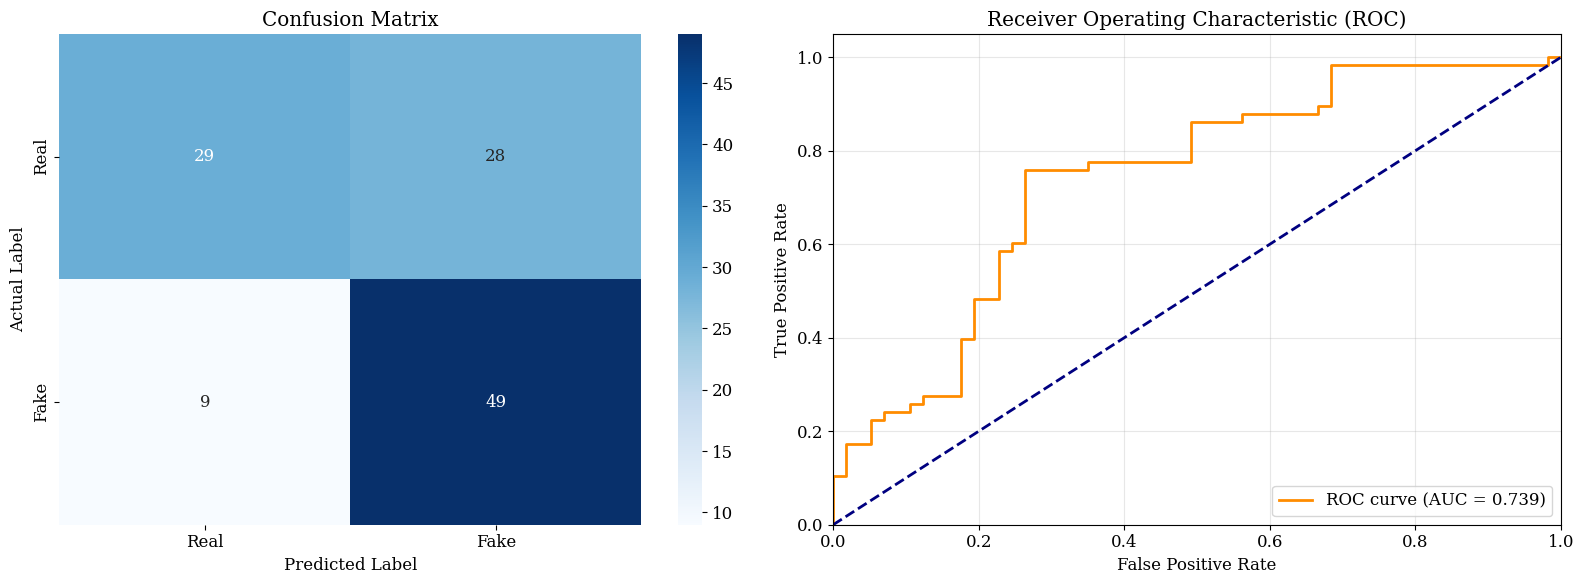

✅ Results saved to 'final_test_results.csv'


In [10]:
# @title Cell 8: Comprehensive Evaluation & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("Loading best model weights...")
try:
    model.load_weights("best_multimodal_model.h5")
    print("✅ Best model weights loaded.")
except:
    print("⚠️ Could not load checkpoint. Using current model weights.")

# 1. Generate Predictions
print("Running inference on Test Set...")
y_true = []
y_pred_probs = []

# Iterate through the test dataset to extract labels and predictions
for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(probs.flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# 2. Quantitative Metrics
print("\n" + "="*50)
print("FINAL TEST RESULTS")
print("="*50)
print(classification_report(y_true, y_pred_binary, target_names=['Real News', 'Fake News']))

# 3. Visualization Setup
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

# Plot B: ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC)')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Save Results for Thesis
results_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Prob': y_pred_probs,
    'Predicted_Label': y_pred_binary
})
results_df.to_csv("final_test_results.csv", index=False)
print("✅ Results saved to 'final_test_results.csv'")

In [16]:
# @title Cell 10: Modality Contribution Analysis (Explainability)
import numpy as np
import tensorflow as tf
import requests
from PIL import Image

def analyze_modality_contribution(headline, image_url):
    print(f"Analyzing: '{headline[:60]}...'")

    # 1. Download & Prepare Image
    headers = {'User-Agent': 'Mozilla/5.0'}
    try:
        content = requests.get(image_url, headers=headers, timeout=5).content
        with open('temp_analysis.jpg', 'wb') as f: f.write(content)
        real_img = preprocess_image_robust('temp_analysis.jpg')
        if real_img is None: return
    except Exception as e:
        print(f"[ERROR] {e}")
        return

    # 2. Prepare Inputs
    # A. Real Data
    enc = tokenizer(headline, padding='max_length', truncation=True, max_length=config.MAX_LEN, return_tensors='tf')
    real_ids = enc['input_ids']
    real_mask = enc['attention_mask']

    # B. "Blinded" Data (Zero Tensors)
    # Blank Image (Black square)
    blank_img = tf.zeros_like(real_img)

    # Blank Text (Empty tokens)
    # RoBERTa padding token ID is 1. We fill with padding.
    blank_ids = tf.ones_like(real_ids)
    blank_mask = tf.zeros_like(real_mask)

    # 3. Run Three Inference Passes
    # Pass 1: Full Multimodal
    prob_full = model.predict([real_ids, real_mask, real_img], verbose=0)[0][0]

    # Pass 2: Text Only (Image is black)
    prob_text = model.predict([real_ids, real_mask, blank_img], verbose=0)[0][0]

    # Pass 3: Image Only (Text is empty)
    prob_img = model.predict([blank_ids, blank_mask, real_img], verbose=0)[0][0]

    # 4. Report
    print("-" * 50)
    print(f"1. Full Model Confidence:   {prob_full:.2%} (Fake Probability)")
    print(f"2. Text-Only Confidence:    {prob_text:.2%}")
    print(f"3. Image-Only Confidence:   {prob_img:.2%}")
    print("-" * 50)

    # Interpretation
    if abs(prob_full - prob_text) > 0.10:
        print("CONCLUSION: The Image played a CRITICAL role in this decision.")
    elif abs(prob_full - prob_img) > 0.10:
        print("CONCLUSION: The Text played a CRITICAL role in this decision.")
    else:
        print("CONCLUSION: Both modalities agreed, or confidence is low.")
    print("=" * 50 + "\n")

# --- Run Analysis on the Shark Hoax ---
fake_headline = "Hurricane floodwaters bring sharks to the highway in Florida."
fake_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/White_shark.jpg/640px-White_shark.jpg"

analyze_modality_contribution(fake_headline, fake_image_url)

Analyzing: 'Hurricane floodwaters bring sharks to the highway in Florida...'
--------------------------------------------------
1. Full Model Confidence:   82.97% (Fake Probability)
2. Text-Only Confidence:    74.23%
3. Image-Only Confidence:   58.50%
--------------------------------------------------
CONCLUSION: The Text played a CRITICAL role in this decision.



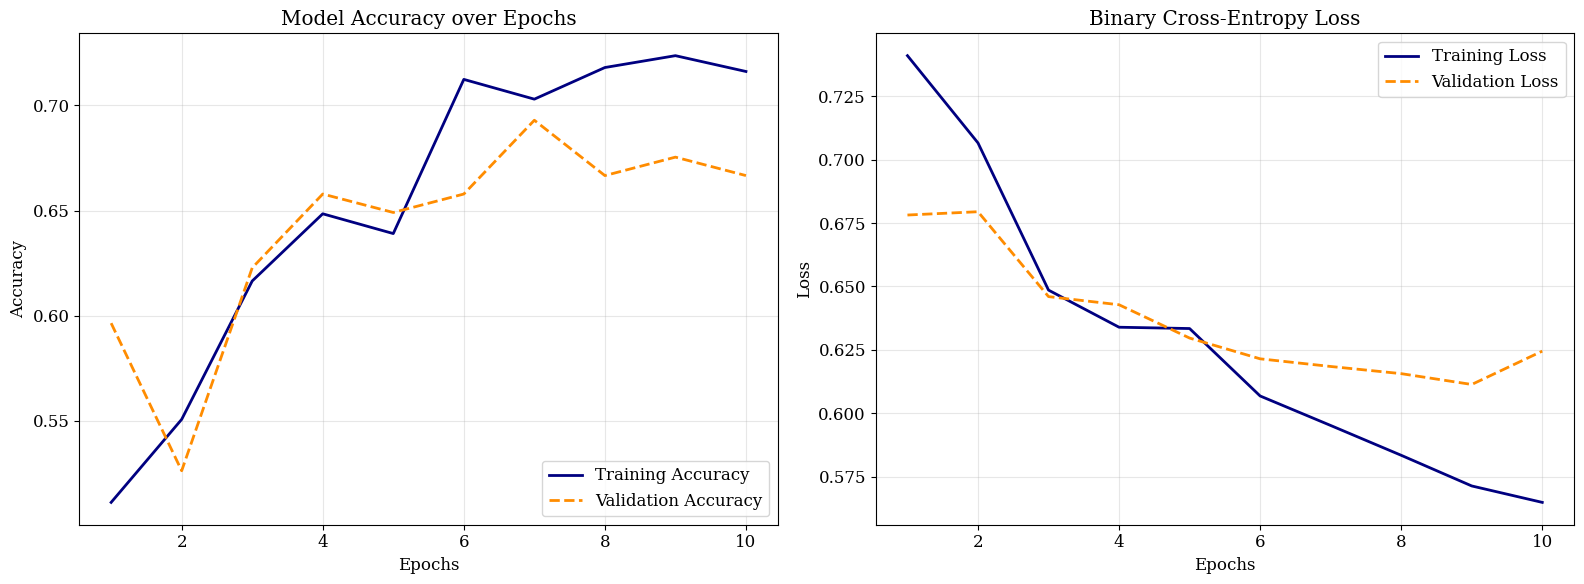

Graphs saved as 'thesis_training_curves.png'


In [15]:
# @title Cell 12: Training Dynamics Visualization
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 6))
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

    # Plot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='navy', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='darkorange', linewidth=2, linestyle='--')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # Plot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='navy', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='darkorange', linewidth=2, linestyle='--')
    plt.title('Binary Cross-Entropy Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("thesis_training_curves.png", dpi=300)
    plt.show()
    print("Graphs saved as 'thesis_training_curves.png'")

# Execute
if 'history' in globals():
    plot_training_history(history)
else:
    print("No training history found. (Did you run Cell 7?)")

In [17]:
# @title Cell 13: Live Deployment with Gradio
# 1. Install Gradio (Silent install)
!pip install -q gradio

import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

def deploy_inference(headline, image):
    """
    Wrapper function for the Web UI.
    Inputs: Text string, PIL Image object
    Output: Dictionary of class probabilities
    """
    if image is None or headline.strip() == "":
        return "Please provide both text and an image."

    # 1. Preprocess Image
    try:
        # Gradio provides a PIL image directly
        img_array = np.array(image.convert('RGB'))
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
        img_tensor = tf.image.resize(img_tensor, config.IMAGE_SIZE, method='bicubic')
        img_tensor = img_tensor / 255.0

        # Normalize
        mean = tf.constant(config.CLIP_MEAN, dtype=tf.float32)
        std = tf.constant(config.CLIP_STD, dtype=tf.float32)
        img_tensor = (img_tensor - mean) / std

        # Batch Dim
        img_tensor = tf.expand_dims(img_tensor, axis=0)

    except Exception as e:
        return f"Image Processing Error: {str(e)}"

    # 2. Preprocess Text
    enc = tokenizer(
        headline,
        padding='max_length',
        truncation=True,
        max_length=config.MAX_LEN,
        return_tensors='tf'
    )

    # 3. Inference
    try:
        prob = model.predict([enc['input_ids'], enc['attention_mask'], img_tensor], verbose=0)[0][0]
    except Exception as e:
        return f"Model Error: {str(e)}"

    # 4. Format Output for Gradio
    # Returns a dictionary {Label: Confidence}
    return {
        "FAKE NEWS": float(prob),
        "REAL NEWS": float(1 - prob)
    }

# --- Design the Interface ---
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # 🕵️‍♂️ Multimodal Disinformation Detector
    **Professional Demo | RoBERTa + CLIP Fusion Architecture**

    Upload an image and a news headline to verify credibility.
    """)

    with gr.Row():
        with gr.Column():
            txt_input = gr.Textbox(label="News Headline", placeholder="Paste the claim here...")
            img_input = gr.Image(type="pil", label="News Image")
            submit_btn = gr.Button("Analyze Veracity", variant="primary")

        with gr.Column():
            label_output = gr.Label(num_top_classes=2, label="Prediction Confidence")

    # Define Examples for users to click
    gr.Examples(
        examples=[
            ["The Eiffel Tower has collapsed after an earthquake.", "temp_test.jpg"], # Uses the last downloaded image
        ],
        inputs=[txt_input, img_input]
    )

    submit_btn.click(
        fn=deploy_inference,
        inputs=[txt_input, img_input],
        outputs=label_output
    )

# --- Launch ---
print("Starting Web Server...")
# share=True generates the public link
demo.launch(share=True, debug=False)

/tmp/ipython-input-2613170583.py:61: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:


Starting Web Server...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://094e9f9f879184316b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
